In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class PointLensModel:
    def __init__(self, f0, t0, y, td):
        """
        f0 is the base flux
        t0 is the time at which the lensing event happens
        y is the maximal flux 
        td is the duration of the event
        """
        self.f0 = f0
        self.t0 = t0
        self.y = y
        self.td = td
    
    def compute_angles(self, ts):
        return np.sqrt(((ts-self.t0)/self.td)**2 + self.y**2)
                       
    def compute_magnification(angle_ratios):
        return (angle_ratios**2 + 2)/(angle_ratios*np.sqrt(angle_ratios**2 + 4))
    
    def compute_fluxes(self, ts):
        angles = self.compute_angles(ts)
        fluxes = PointLensModel.compute_magnification(angles)*self.f0
        return fluxes
    
    def plot_range(self, st, et, counts = 100):
        ts = np.linspace(st, et, counts)
        fluxes = self.compute_fluxes(ts)
        plt.plot(ts, fluxes)
        plt.show()
    
        

In [37]:
model = PointLensModel(1, 2, 0.9, 2)

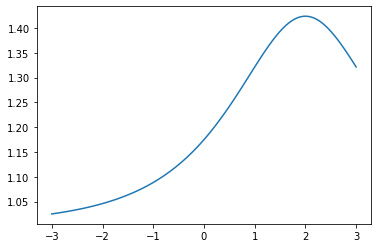

In [38]:
model.plot_range(-3, 3)